# 6. Audio extraction

<img src="https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/media/overview/content-understanding-framework-2025.png#lightbox">

Azure Content Understanding in Foundry Tools is an Foundry Tool that's available as part of the Microsoft Foundry Resource in the Azure portal. It uses generative AI to process/ingest content of many types (documents, images, videos, and audio) into a user-defined output format. Content Understanding offers a streamlined process to reason over large amounts of unstructured data, accelerating time-to-value by generating an output that can be integrated into automation and analytical workflows.

Content Understanding is now a Generally Available (GA) service with the release of the 2025-11-01 API version. It's now available in a broader range of regions.

### Core Documentation
1. **[What is Azure Content Understanding in Foundry Tools?](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/overview)** - Main overview page
2. **[FAQ - Frequently Asked Questions](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/faq)** - Common questions and answers
3. **[Choosing the Right Tool: Document Intelligence vs Content Understanding](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/choosing-right-ai-tool)** - Comparison guide
4. **[Models and Deployments](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/concepts/models-deployments)** - Supported models configuration
5. **[Pricing Explainer](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/pricing-explainer)** - Pricing details and optimization

### Modality-Specific Documentation
6. **[Document Processing Overview](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/document/overview)** - Field extraction and grounding
7. **[Video Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/overview)** - Video analysis capabilities
8. **[Image Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/image/overview)** - Image extraction and analysis
9. **[Face Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/face/overview)** - Face detection and recognition

### Additional Resources
10. **[Transparency Note](https://learn.microsoft.com/en-us/azure/ai-foundry/responsible-ai/content-understanding/transparency-note)** - Responsible AI information
11. **[Code Samples on GitHub](https://github.com/Azure-Samples/azure-ai-content-understanding-python)** - Python implementation examples
12. **[Azure Content Understanding Pricing](https://azure.microsoft.com/pricing/details/content-understanding/)** - Official pricing page

## Audio Content
The `prebuilt-audioSearch` analyzer provides conversation analysis capabilities for audio files. It automatically transcribes audio content, performs speaker diarization to distinguish between speakers, and generates conversation summaries. The analyzer supports multilingual transcription and outputs transcripts in standard WebVTT format.

Key features include:
1. **Transcription:** Converts conversational audio into searchable text with sentence-level and word-level timestamps.
2. **Speaker Diarization:** Distinguishes between speakers in a conversation, attributing parts of the transcript to specific speakers (e.g., "Speaker 1", "Speaker 2").
3. **Timing Information:** Precise timing data in milliseconds (startTimeMs, endTimeMs) for each phrase, crucial for audio-text synchronization.
4. **Summary Generation:** Automatically generates a summary of the conversation for quick understanding.
5. **Multilingual Support:** Supports automatic language detection and multilingual transcription across multiple locales.
6. **Markdown Output:** Structured markdown format with WebVTT transcripts preserving speaker identification and timing.

For detailed information about audio markdown format and capabilities, see [Audio overview](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/audio/overview) and [AudioVisual markdown representation](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/markdown).

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import soundfile as sf
import sys

from azure.identity import DefaultAzureCredential
from datetime import datetime
from dotenv import load_dotenv
from helper.content_understanding_client import AzureContentUnderstandingClient
from helper.document_processor import DocumentProcessor
from helper.sample_helper import save_json_to_file 
from IPython.display import Audio, FileLink
from PIL import Image

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 02-Dec-2025 13:27:54


## 1. Azure Content Understanding client

In [4]:
load_dotenv("azure.env")

AZURE_AI_ENDPOINT = os.getenv("AZURE_AI_ENDPOINT")
API_VERSION = "2025-11-01"  # Subject to change. Check the documentation
GPT_4_1_DEPLOYMENT = "gpt-4.1"  # Name of the model deployed in Microsoft Foundry
GPT_4_1_MINI_DEPLOYMENT = "gpt-4.1-mini"  # Name of the model deployed in Microsoft Foundry
TEXT_EMBEDDING_3_LARGE_DEPLOYMENT = "text-embedding-3-large"  # Name of the model deployed in Microsoft Foundry

In [5]:
def token_provider():
    """Provides fresh Azure Cognitive Services tokens."""
    try:
        credential = DefaultAzureCredential()
        token = credential.get_token(
            "https://cognitiveservices.azure.com/.default")
        return token.token
    except Exception as e:
        print(f"❌ Token acquisition failed: {e}")
        raise


try:
    if not AZURE_AI_ENDPOINT or not API_VERSION:
        raise ValueError("AZURE_AI_ENDPOINT and API_VERSION must be set")

    print("Initializing Azure Content Understanding Client...")
    client = AzureContentUnderstandingClient(
        endpoint=AZURE_AI_ENDPOINT,
        api_version=API_VERSION,
        token_provider=token_provider,
        x_ms_useragent="azure-ai-content-understanding-python-sample-ga")
    print("✅ Done")

except ValueError as e:
    print(f"❌ Configuration error: {e}")
    raise
except Exception as e:
    print(f"❌ Client creation failed: {e}")
    raise

Initializing Azure Content Understanding Client...
✅ Done


In [6]:
missing_deployments = []

if not GPT_4_1_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_DEPLOYMENT")
if not GPT_4_1_MINI_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_MINI_DEPLOYMENT")
if not TEXT_EMBEDDING_3_LARGE_DEPLOYMENT:
    missing_deployments.append("TEXT_EMBEDDING_3_LARGE_DEPLOYMENT")

if missing_deployments:
    print(f"❌ Warning: Missing required model deployment configuration(s):")
    for deployment in missing_deployments:
        print(f"   - {deployment}")
    print(
        "\n   Prebuilt analyzers require GPT-4.1, GPT-4.1-mini, and text-embedding-3-large deployments."
    )
    print("   Please:")
    print("   1. Deploy all three models in Azure AI Foundry")
    print("   2. Add the following to notebooks/.env:")
    print("      GPT_4_1_DEPLOYMENT=<your-gpt-4.1-deployment-name>")
    print("      GPT_4_1_MINI_DEPLOYMENT=<your-gpt-4.1-mini-deployment-name>")
    print(
        "      TEXT_EMBEDDING_3_LARGE_DEPLOYMENT=<your-text-embedding-3-large-deployment-name>"
    )
    print("   3. Restart the kernel and run this cell again")

else:
    print(f"📋 Configuring default model deployments...")
    print(f"   GPT-4.1 deployment: {GPT_4_1_DEPLOYMENT}")
    print(f"   GPT-4.1-mini deployment: {GPT_4_1_MINI_DEPLOYMENT}")
    print(
        f"   text-embedding-3-large deployment: {TEXT_EMBEDDING_3_LARGE_DEPLOYMENT}"
    )
    try:
        result = client.update_defaults({
            "gpt-4.1":
            GPT_4_1_DEPLOYMENT,
            "gpt-4.1-mini":
            GPT_4_1_MINI_DEPLOYMENT,
            "text-embedding-3-large":
            TEXT_EMBEDDING_3_LARGE_DEPLOYMENT
        })
        print(f"\n✅ Default model deployments configured successfully")
        print(f"   Model mappings:")
        for model, deployment in result.get("modelDeployments", {}).items():
            print(f"     {model} → {deployment}")
    except Exception as e:
        print(f"❌ Failed to configure defaults: {e}")
        print(f"   This may happen if:")
        print(
            f"   - One or more deployment names don't exist in your Azure AI Foundry project"
        )
        print(f"   - You don't have permission to update defaults")
        raise

📋 Configuring default model deployments...
   GPT-4.1 deployment: gpt-4.1
   GPT-4.1-mini deployment: gpt-4.1-mini
   text-embedding-3-large deployment: text-embedding-3-large

✅ Default model deployments configured successfully
   Model mappings:
     gpt-4.1 → gpt-4.1
     gpt-4.1-mini → gpt-4.1-mini
     text-embedding-3-large → text-embedding-3-large


In [7]:
try:
    defaults = client.get_defaults()
    print(f"✅ Retrieved default settings")

    model_deployments = defaults.get("modelDeployments", {})

    if model_deployments:
        print(f"\n✅ Model Deployments:")
        for model_name, deployment_name in model_deployments.items():
            print(f"   {model_name}: {deployment_name}")
    else:
        print("❌ No model deployments configured")

except Exception as e:
    print(f"❌  Error retrieving defaults: {e}")
    print("This is expected if no defaults have been configured yet.")

✅ Retrieved default settings

✅ Model Deployments:
   gpt-4.1: gpt-4.1
   gpt-4.1-mini: gpt-4.1-mini
   text-embedding-3-large: text-embedding-3-large


## 2. Audio file

In [8]:
audio_file = 'documents/audio.mp3'

!ls $audio_file -lh

-rwxrwxrwx 1 root root 503K Dec  1 16:20 documents/audio.mp3


In [9]:
Audio(audio_file, autoplay=False)

In [10]:
def plot_audio_amplitude(audio_file_path):
    """
    Load an audio file and display its amplitude plot
    
    Parameters:
    audio_file_path (str): Path to the audio file
    """
    try:
        # Load the audio file
        # librosa loads as float32 normalized between -1 and 1
        audio_data, sample_rate = librosa.load(audio_file_path,
                                               sr=None,
                                               mono=False)

        # If stereo, convert to mono for simpler visualization
        if audio_data.ndim > 1:
            audio_data = np.mean(audio_data, axis=0)

        # Create time axis in seconds
        duration = len(audio_data) / sample_rate
        time = np.linspace(0, duration, len(audio_data))

        # Create the plot
        plt.figure(figsize=(14, 6))
        plt.plot(time, audio_data, linewidth=0.5, color='blue')
        plt.xlabel('Time (seconds)', fontsize=12)
        plt.ylabel('Amplitude', fontsize=12)
        plt.title(
            f'Audio Amplitude Waveform\nSample Rate: {sample_rate} Hz, Duration: {duration:.2f} seconds',
            fontsize=14,
            fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Display the plot
        plt.show()

        # Print some basic info
        print(f"Sample rate: {sample_rate} Hz")
        print(f"Duration: {duration:.2f} seconds")
        print(f"Number of samples: {len(audio_data)}")
        print(
            f"Amplitude range: [{audio_data.min():.4f}, {audio_data.max():.4f}]"
        )

    except Exception as e:
        print(f"Error loading audio file: {e}")
        print("\nMake sure you have the required libraries installed:")
        print("pip install librosa soundfile matplotlib numpy")

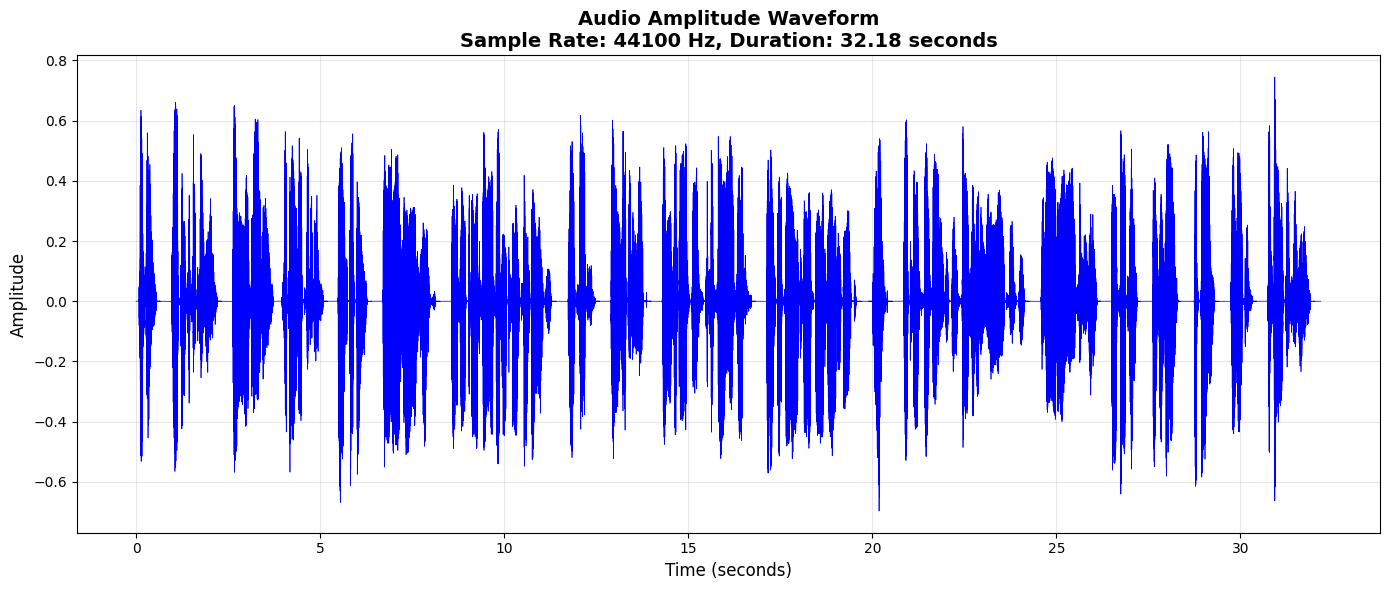

Sample rate: 44100 Hz
Duration: 32.18 seconds
Number of samples: 1419264
Amplitude range: [-0.6967, 0.7446]


In [11]:
plot_audio_amplitude(audio_file)

In [12]:
analyzer_id = 'prebuilt-audioSearch'

# Analyze audio file with the created analyzer
print(
    f"🔍 Analyzing audio file from path: {audio_file} with analyzer '{analyzer_id}'..."
)

# Begin audio analysis operation
print(f"🎬 Starting audio analysis with analyzer '{analyzer_id}'...")
analysis_response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=audio_file,
)

# Wait for analysis completion
print(f"⏳ Waiting for audio analysis to complete...")
analysis_result = client.poll_result(analysis_response)
print(f"✅ Done")

🔍 Analyzing audio file from path: documents/audio.mp3 with analyzer 'prebuilt-audioSearch'...
🎬 Starting audio analysis with analyzer 'prebuilt-audioSearch'...
⏳ Waiting for audio analysis to complete...
✅ Done


In [13]:
print("📄 Markdown Content\n")
print("\033[1;31;34m")

contents = analysis_result.get("result", {}).get("contents", [])
if contents:
    content = contents[0]
    markdown = content.get("markdown", "")
    print(markdown)

📄 Markdown Content


# Audio: 00:00.000 => 00:32.183

Transcript
```
WEBVTT

00:00.080 --> 00:00.640
<v Speaker 1>Good day.

00:00.880 --> 00:02.240
<v Speaker 1>Welcome to Contoso.

00:02.560 --> 00:03.760
<v Speaker 1>My name is John Doe.

00:03.920 --> 00:05.120
<v Speaker 1>How can I help you today?

00:05.440 --> 00:06.320
<v Speaker 2>Yes, good day.

00:06.640 --> 00:08.160
<v Speaker 2>My name is Maria Smith.

00:08.560 --> 00:11.360
<v Speaker 2>I would like to inquire about my current point balance.

00:11.680 --> 00:12.560
<v Speaker 1>No problem.

00:12.880 --> 00:13.920
<v Speaker 1>I am happy to help.

00:14.240 --> 00:16.720
<v Speaker 1>I need your date of birth to confirm your identity.

00:17.120 --> 00:19.600
<v Speaker 2>It is April 19th, 1988.

00:20.000 --> 00:20.480
<v Speaker 1>Great.

00:20.800 --> 00:24.160
<v Speaker 1>Your current point balance is 599 points.

00:24.560 --> 00:26.160
<v Speaker 1>Do you need any more information?

00:26.480 --> 00:27.200
<v S

In [14]:
if content.get("kind") == "audioVisual":
    audio_visual_content = content
    print("\033[1;31;34m")
    print("🎙️ Audio-Visual Information\n")

    try:
        start_time = audio_visual_content.get("startTimeMs")
        end_time = audio_visual_content.get("endTimeMs")
        duration_sec = (end_time - start_time) / 1000
        print(f"Start Time: {start_time} ms")
        print(f"End Time: {end_time} ms")
        print(f"Duration: {duration_sec:.2f} seconds")
    except (KeyError, TypeError):
        print("❌ Missing basic audio-visual content details.")

    # Transcript Phrases (limit to 10)
    transcript_phrases = audio_visual_content.get("transcriptPhrases", [])
    if transcript_phrases:
        print(f"\n📝 Transcript Phrases ({min(len(transcript_phrases), 10)}):")
        for idx, phrase in enumerate(transcript_phrases[:10]):
            print(f"  {idx + 1}. Speaker: {phrase.get('speaker')}")
            print(f"     Text: {phrase.get('text')}")
            print(
                f"     Start: {phrase.get('startTimeMs')} ms, End: {phrase.get('endTimeMs')} ms"
            )
            confidence = phrase.get('confidence', 0)
            print(f"     Confidence: {confidence:.2%}")
            print(f"     Locale: {phrase.get('locale')}")
        if len(transcript_phrases) > 10:
            print(f"  ... and {len(transcript_phrases) - 10} more.")
    else:
        print("\n📝 No transcript phrases available.")

    # Markdown Preview
    if markdown:
        print("\n🎵 Markdown Content Preview:")
        print(markdown[:200] + ("..." if len(markdown) > 200 else ""))
    else:
        print("\n🎵 No Markdown content available.")
else:
    print(
        "\n🎙️ Audio-Visual Information: Not available for this content type.")


🎙️ Audio-Visual Information

Start Time: 0 ms
End Time: 32183 ms
Duration: 32.18 seconds

📝 Transcript Phrases (10):
  1. Speaker: Speaker 1
     Text: Good day.
     Start: 80 ms, End: 640 ms
     Confidence: 92.50%
     Locale: en-US
  2. Speaker: Speaker 1
     Text: Welcome to Contoso.
     Start: 880 ms, End: 2240 ms
     Confidence: 92.50%
     Locale: en-US
  3. Speaker: Speaker 1
     Text: My name is John Doe.
     Start: 2560 ms, End: 3760 ms
     Confidence: 92.50%
     Locale: en-US
  4. Speaker: Speaker 1
     Text: How can I help you today?
     Start: 3920 ms, End: 5120 ms
     Confidence: 92.50%
     Locale: en-US
  5. Speaker: Speaker 2
     Text: Yes, good day.
     Start: 5440 ms, End: 6320 ms
     Confidence: 92.50%
     Locale: en-US
  6. Speaker: Speaker 2
     Text: My name is Maria Smith.
     Start: 6640 ms, End: 8160 ms
     Confidence: 92.50%
     Locale: en-US
  7. Speaker: Speaker 2
     Text: I would like to inquire about my current point balance.
     St

In [15]:
saved_json_path = save_json_to_file(analysis_result,
                                    filename_prefix="content_analyzers_audio")
print(
    f"📋 Full analysis result saved. Review the complete JSON at: {saved_json_path}"
)

💾 Analysis result saved to: results/content_analyzers_audio_20251202_132814.json
📋 Full analysis result saved. Review the complete JSON at: results/content_analyzers_audio_20251202_132814.json


In [16]:
!ls $saved_json_path -lh

-rwxrwxrwx 1 root root 19K Dec  2 13:28 results/content_analyzers_audio_20251202_132814.json
